In [1]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-06-23 12:35:25--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  2.98MB/s    in 2m 1s   

2021-06-23 12:37:27 (2.54 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
import zipfile, os
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# extract file 
zip_path = '/tmp/rockpaperscissors.zip'
zip_file = zipfile.ZipFile(zip_path, 'r')
zip_file.extractall('/tmp')
zip_file.close()

In [4]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.95):
      keys = list(logs.keys())
      print("Start epoch {} of training; got log keys: {}".format(epoch, keys))
      self.model.stop_training = True

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   fill_mode='wrap',
                                   validation_split=0.4
                                   )

In [6]:
train_generator = train_datagen.flow_from_directory(
    '/tmp/rockpaperscissors/rps-cv-images',
    target_size=(150, 150), 
    batch_size=32,
    shuffle=True, 
    class_mode='categorical',
    subset='training', 
)

validation_generator = train_datagen.flow_from_directory(
    '/tmp/rockpaperscissors/rps-cv-images',
    target_size=(150, 150),
    batch_size=32,
    shuffle=True, 
    class_mode='categorical',
    subset='validation' 
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(), 
              metrics=['accuracy'])

In [9]:
callback = MyCallback()

history = model.fit(train_generator,
          steps_per_epoch=25,
          epochs=20,
          validation_data = validation_generator,
          validation_steps=5,
          verbose=2,
          callbacks=[callback])

Epoch 1/20
25/25 - 45s - loss: 0.9769 - accuracy: 0.5288 - val_loss: 0.5906 - val_accuracy: 0.7812
Epoch 2/20
25/25 - 42s - loss: 0.5687 - accuracy: 0.7896 - val_loss: 0.2713 - val_accuracy: 0.8875
Epoch 3/20
25/25 - 43s - loss: 0.2743 - accuracy: 0.8963 - val_loss: 0.3019 - val_accuracy: 0.8750
Epoch 4/20
25/25 - 43s - loss: 0.2739 - accuracy: 0.9150 - val_loss: 0.1874 - val_accuracy: 0.9500
Epoch 5/20
25/25 - 43s - loss: 0.1980 - accuracy: 0.9325 - val_loss: 0.2560 - val_accuracy: 0.9375
Epoch 6/20
25/25 - 41s - loss: 0.1871 - accuracy: 0.9312 - val_loss: 0.2325 - val_accuracy: 0.9062
Epoch 7/20
25/25 - 43s - loss: 0.1506 - accuracy: 0.9513 - val_loss: 0.0991 - val_accuracy: 0.9688
Start epoch 6 of training; got log keys: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


In [10]:
evaluate_score = model.evaluate(validation_generator, steps=20)
print('Loss Score', evaluate_score[0])
print('Accuracy Score', evaluate_score[1])

20/20 [==============================] - 12s 580ms/step - loss: 0.1579 - accuracy: 0.9469
Loss Score 0.15794086456298828
Accuracy Score 0.9468749761581421


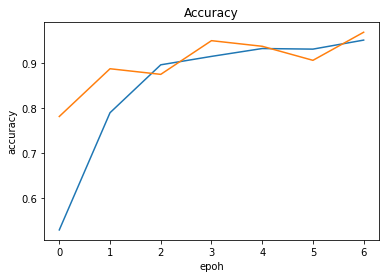

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoh')
plt.show()

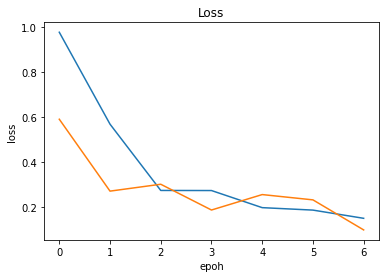

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoh')
plt.show()

In [13]:
#convert model 
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5agldzs_/assets


In [14]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)